<a href="https://colab.research.google.com/github/Jefffish09/MachineLearning/blob/dev/Classification/binary/bert_binary_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References:

* https://www.tensorflow.org/tutorials/text/classify_text_with_bert


In [1]:
!pip install -U -q tensorflow-text
!pip install -U -q tf-models-official

     |████████████████████████████████| 3.4MB 5.9MB/s 
     |████████████████████████████████| 1.1MB 5.5MB/s 
     |████████████████████████████████| 37.6MB 84kB/s 
     |████████████████████████████████| 1.2MB 57.6MB/s 
     |████████████████████████████████| 706kB 43.1MB/s 
     |████████████████████████████████| 645kB 54.0MB/s 
     |████████████████████████████████| 102kB 13.7MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 174kB 56.4MB/s 
     |████████████████████████████████| 358kB 56.1MB/s 


In [2]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.utils import get_file, plot_model
from tensorflow.keras.preprocessing import text_dataset_from_directory
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.data.experimental import cardinality
from tensorflow_hub import KerasLayer
import tensorflow_text
from official.nlp import optimization  # to create AdamW optmizer
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold


In [3]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 2021
epochs = 100
lr = 3e-5
earlystopping_patience = 3

In [4]:
# Download the IMDB dataset

url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = get_file("aclImdb_v1.tar.gz", url, untar=True, cache_dir=".", cache_subdir="")

dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")
train_dir = os.path.join(dataset_dir, "train")

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, "unsup")
shutil.rmtree(remove_dir)

# Training dataset
raw_train_ds = text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed)
class_names = raw_train_ds.class_names
print("Class names: {}".format(class_names))
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Validation dataset
val_ds = text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Tesing dataset
test_ds = text_dataset_from_directory(
    "aclImdb/test",
    batch_size=batch_size)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

84131840/84125825 [==============================] - 7s 0us/step
Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Class names: ['neg', 'pos']
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [5]:
# Choose a BERT model to fine-tune

map_name_to_handle = {
    "bert_en_uncased_L-12_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3",
    "bert_en_cased_L-12_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3",
    "bert_multi_cased_L-12_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3",
    "small_bert/bert_en_uncased_L-2_H-128_A-2":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1",
    "small_bert/bert_en_uncased_L-2_H-256_A-4":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1",
    "small_bert/bert_en_uncased_L-2_H-512_A-8":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1",
    "small_bert/bert_en_uncased_L-2_H-768_A-12":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1",
    "small_bert/bert_en_uncased_L-4_H-128_A-2":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1",
    "small_bert/bert_en_uncased_L-4_H-256_A-4":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1",
    "small_bert/bert_en_uncased_L-4_H-512_A-8":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1",
    "small_bert/bert_en_uncased_L-4_H-768_A-12":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1",
    "small_bert/bert_en_uncased_L-6_H-128_A-2":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1",
    "small_bert/bert_en_uncased_L-6_H-256_A-4":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1",
    "small_bert/bert_en_uncased_L-6_H-512_A-8":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1",
    "small_bert/bert_en_uncased_L-6_H-768_A-12":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1",
    "small_bert/bert_en_uncased_L-8_H-128_A-2":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1",
    "small_bert/bert_en_uncased_L-8_H-256_A-4":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1",
    "small_bert/bert_en_uncased_L-8_H-512_A-8":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1",
    "small_bert/bert_en_uncased_L-8_H-768_A-12":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1",
    "small_bert/bert_en_uncased_L-10_H-128_A-2":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1",
    "small_bert/bert_en_uncased_L-10_H-256_A-4":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1",
    "small_bert/bert_en_uncased_L-10_H-512_A-8":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1",
    "small_bert/bert_en_uncased_L-10_H-768_A-12":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1",
    "small_bert/bert_en_uncased_L-12_H-128_A-2":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1",
    "small_bert/bert_en_uncased_L-12_H-256_A-4":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1",
    "small_bert/bert_en_uncased_L-12_H-512_A-8":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1",
    "small_bert/bert_en_uncased_L-12_H-768_A-12":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1",
    "albert_en_base":
        "https://tfhub.dev/tensorflow/albert_en_base/2",
    "electra_small":
        "https://tfhub.dev/google/electra_small/2",
    "electra_base":
        "https://tfhub.dev/google/electra_base/2",
    "experts_pubmed":
        "https://tfhub.dev/google/experts/bert/pubmed/2",
    "experts_wiki_books":
        "https://tfhub.dev/google/experts/bert/wiki_books/2",
    "talking-heads_base":
        "https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1",
}

map_model_to_preprocess = {
    "bert_en_uncased_L-12_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "bert_en_cased_L-12_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3",
    "small_bert/bert_en_uncased_L-2_H-128_A-2":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-2_H-256_A-4":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-2_H-512_A-8":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-2_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-4_H-128_A-2":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-4_H-256_A-4":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-4_H-512_A-8":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-4_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-6_H-128_A-2":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-6_H-256_A-4":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-6_H-512_A-8":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-6_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-8_H-128_A-2":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-8_H-256_A-4":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-8_H-512_A-8":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-8_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-10_H-128_A-2":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-10_H-256_A-4":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-10_H-512_A-8":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-10_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-12_H-128_A-2":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-12_H-256_A-4":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-12_H-512_A-8":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-12_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "bert_multi_cased_L-12_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3",
    "albert_en_base":
        "https://tfhub.dev/tensorflow/albert_en_preprocess/2",
    "electra_small":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "electra_base":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "experts_pubmed":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "experts_wiki_books":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "talking-heads_base":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
}

bert_model_name = "small_bert/bert_en_uncased_L-4_H-512_A-8" 
tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f"BERT model selected: {tfhub_handle_encoder}")
print(f"Preprocess model auto-selected: {tfhub_handle_preprocess}")

BERT model selected: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [6]:
def plot_perf(history):
  # Create a plot of accuracy and loss over time
  history_dict = history.history
  history_dict.keys()

  acc = history_dict["binary_accuracy"]
  val_acc = history_dict["val_binary_accuracy"]
  loss = history_dict["loss"]
  val_loss = history_dict["val_loss"]

  epochs = range(1, len(acc) + 1)

  # Use plot styling from seaborn.
  sns.set(style="darkgrid")
  # Increase the plot size and font size.
  sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] = (12, 6)

  # Training and validation loss
  plt.plot(epochs, loss, "r", label="Training loss")
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

  # Training and validation accuracy
  plt.plot(epochs, acc, "r", label="Training acc")
  plt.plot(epochs, val_acc, "b", label="Validation acc")
  plt.title("Training and validation accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(loc="lower right")
  plt.show()

KFold: 1 starts.
Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 108s 179ms/step - loss: 0.7058 - binary_accuracy: 0.5236 - val_loss: 0.5484 - val_binary_accuracy: 0.7000
Epoch 2/100
563/563 [==============================] - 100s 177ms/step - loss: 0.5152 - binary_accuracy: 0.7251 - val_loss: 0.4280 - val_binary_accuracy: 0.8004
Epoch 3/100
563/563 [==============================] - 99s 176ms/step - loss: 0.4090 - binary_accuracy: 0.8065 - val_loss: 0.4154 - val_binary_accuracy: 0.8230
Epoch 4/100
563/563 [==============================] - 100s 177ms/step - loss: 0.3515 - binary_accuracy: 0.8395 - val_loss: 0.3931 - val_binary_accuracy: 0.8294
Epoch 5/100
563/563 [==============================] - 99s 176ms/step - loss: 0.3027 - binary_accuracy: 0.8693 - val_loss: 0.3784 - val_binary_accuracy: 0.8310
Epoch 6/100
563/563 [==============================] - 99s 176ms/step - loss: 0.2627 - b

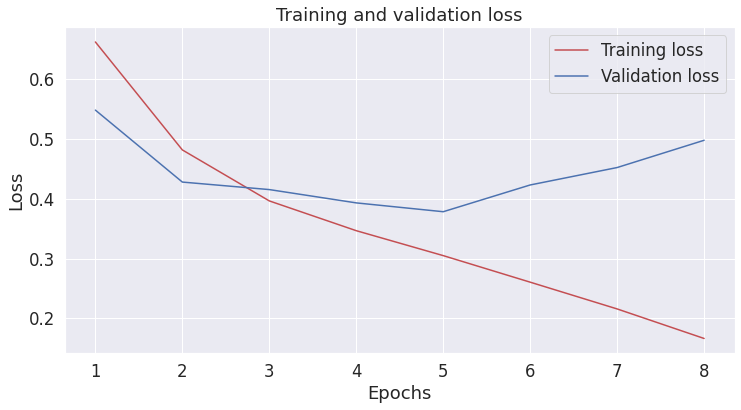

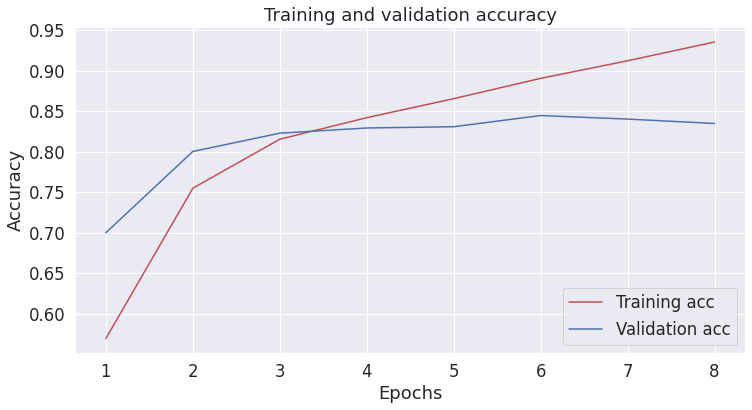

              precision    recall  f1-score   support

           0      0.823     0.876     0.849     12500
           1      0.867     0.812     0.839     12500

    accuracy                          0.844     25000
   macro avg      0.845     0.844     0.844     25000
weighted avg      0.845     0.844     0.844     25000


KFold: 2 starts.
Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 105s 178ms/step - loss: 0.6912 - binary_accuracy: 0.5441 - val_loss: 0.5370 - val_binary_accuracy: 0.7186
Epoch 2/100
563/563 [==============================] - 100s 177ms/step - loss: 0.5116 - binary_accuracy: 0.7277 - val_loss: 0.4215 - val_binary_accuracy: 0.7896
Epoch 3/100
563/563 [==============================] - 100s 177ms/step - loss: 0.4027 - binary_accuracy: 0.8096 - val_loss: 0.4246 - val_binary_accuracy: 0.8182
Epoch 4/100
563/563 [==============================] - 100s 177ms/step - loss: 0

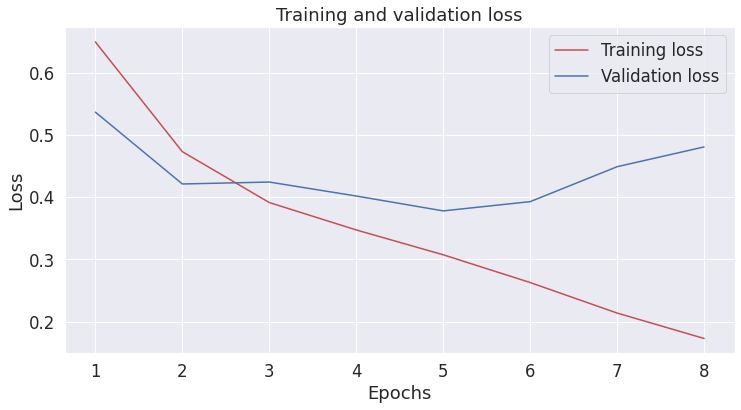

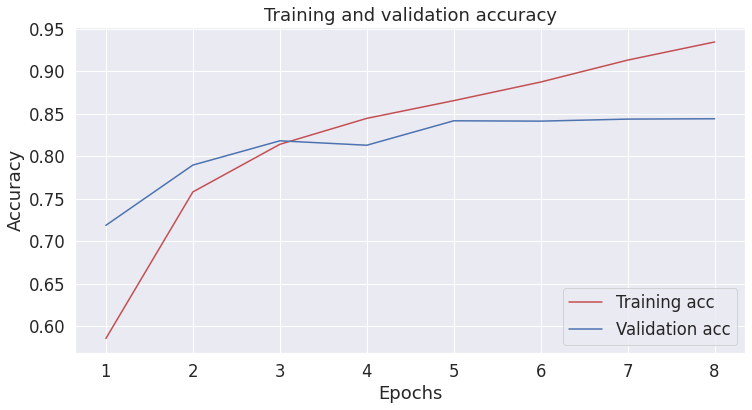

              precision    recall  f1-score   support

           0      0.848     0.849     0.849     12500
           1      0.849     0.848     0.849     12500

    accuracy                          0.849     25000
   macro avg      0.849     0.849     0.849     25000
weighted avg      0.849     0.849     0.849     25000


KFold: 3 starts.


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 106s 179ms/step - loss: 0.7238 - binary_accuracy: 0.5426 - val_loss: 0.5500 - val_binary_accuracy: 0.7148
Epoch 2/100
563/563 [==============================] - 100s 178ms/step - loss: 0.5177 - binary_accuracy: 0.7285 - val_loss: 0.4354 - val_binary_accuracy: 0.7988
Epoch 3/100
563/563 [==============================] - 100s 178ms/step - loss: 0.4101 - binary_accuracy: 0.8050 - val_loss: 0.3984 - val_binary_accuracy: 0.8178
Epoch 4/100
563/563 [==============================] - 100s 178ms/step - loss: 0.3567 - binary_accuracy: 0.8370 - val_loss: 0.4162 - val_binary_accuracy: 0.8284
Epoch 5/100
563/563 [==============================] - 100s 178ms/step - loss: 0.3007 - binary_accuracy: 0.8682 - val_loss: 0.3905 - val_binary_accuracy: 0.8254
Epoch 6/100
563/563 [==============================] - 100s 178ms/step - loss: 0.2627 - binary_accuracy

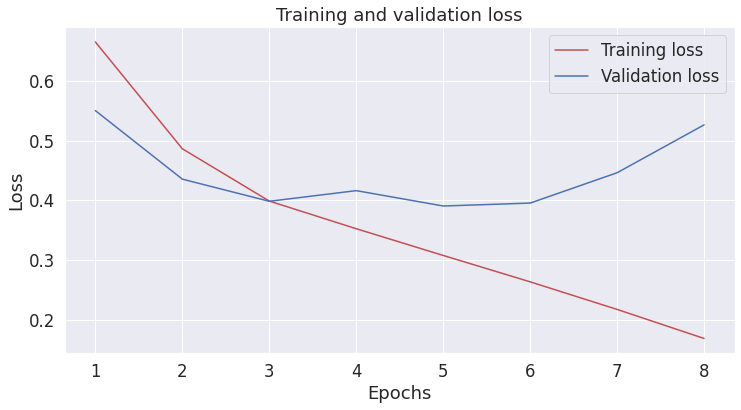

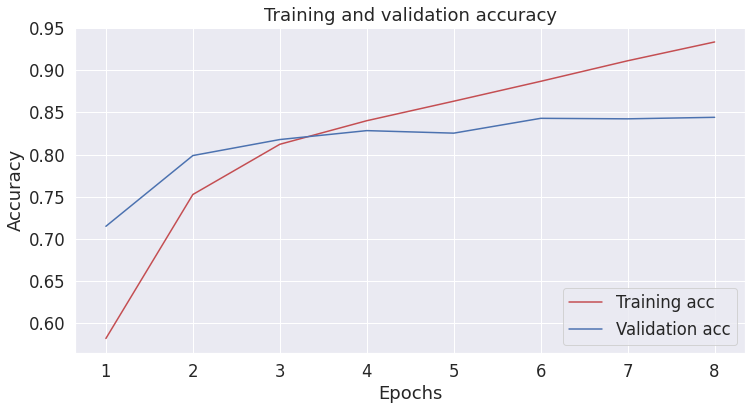

              precision    recall  f1-score   support

           0      0.793     0.910     0.848     12500
           1      0.895     0.763     0.824     12500

    accuracy                          0.837     25000
   macro avg      0.844     0.837     0.836     25000
weighted avg      0.844     0.837     0.836     25000


KFold: 4 starts.


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 107s 181ms/step - loss: 0.7185 - binary_accuracy: 0.5111 - val_loss: 0.5660 - val_binary_accuracy: 0.6550
Epoch 2/100
563/563 [==============================] - 101s 180ms/step - loss: 0.5235 - binary_accuracy: 0.7216 - val_loss: 0.4344 - val_binary_accuracy: 0.7910
Epoch 3/100
563/563 [==============================] - 101s 180ms/step - loss: 0.3999 - binary_accuracy: 0.8129 - val_loss: 0.4026 - val_binary_accuracy: 0.8040
Epoch 4/100
563/563 [==============================] - 101s 180ms/step - loss: 0.3521 - binary_accuracy: 0.8367 - val_loss: 0.4014 - val_binary_accuracy: 0.8326
Epoch 5/100
563/563 [==============================] - 101s 179ms/step - loss: 0.3068 - binary_accuracy: 0.8609 - val_loss: 0.3916 - val_binary_accuracy: 0.8260
Epoch 6/100
563/563 [==============================] - 101s 180ms/step - loss: 0.2597 - binary_accuracy

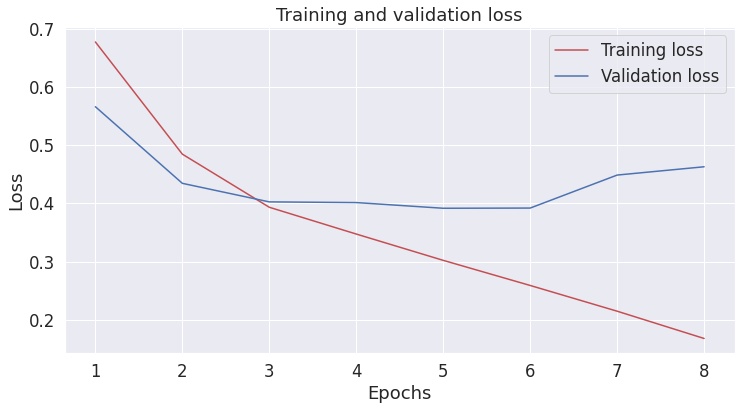

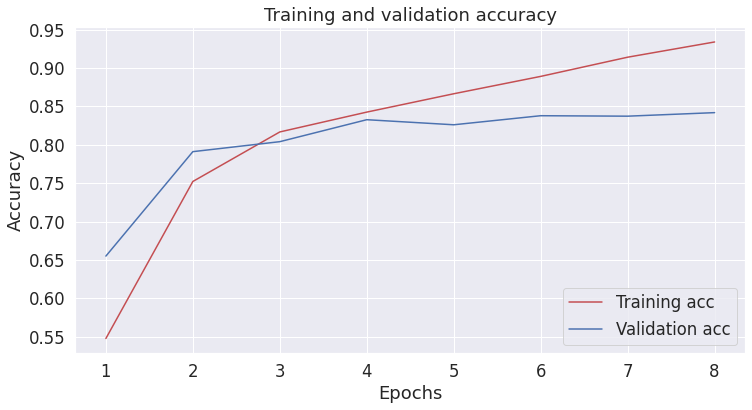

              precision    recall  f1-score   support

           0      0.807     0.895     0.849     12500
           1      0.882     0.786     0.832     12500

    accuracy                          0.841     25000
   macro avg      0.845     0.841     0.840     25000
weighted avg      0.845     0.841     0.840     25000


KFold: 5 starts.


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 108s 182ms/step - loss: 0.7794 - binary_accuracy: 0.5201 - val_loss: 0.5296 - val_binary_accuracy: 0.7290
Epoch 2/100
563/563 [==============================] - 102s 181ms/step - loss: 0.5082 - binary_accuracy: 0.7363 - val_loss: 0.4436 - val_binary_accuracy: 0.8046
Epoch 3/100
563/563 [==============================] - 102s 181ms/step - loss: 0.4033 - binary_accuracy: 0.8095 - val_loss: 0.3973 - val_binary_accuracy: 0.8150
Epoch 4/100
563/563 [==============================] - 102s 181ms/step - loss: 0.3549 - binary_accuracy: 0.8394 - val_loss: 0.3896 - val_binary_accuracy: 0.8282
Epoch 5/100
563/563 [==============================] - 102s 181ms/step - loss: 0.3210 - binary_accuracy: 0.8573 - val_loss: 0.3901 - val_binary_accuracy: 0.8308
Epoch 6/100
563/563 [==============================] - 102s 181ms/step - loss: 0.2558 - binary_accuracy

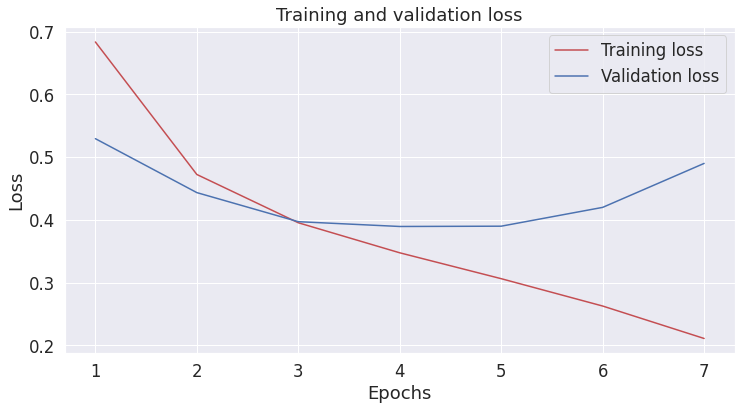

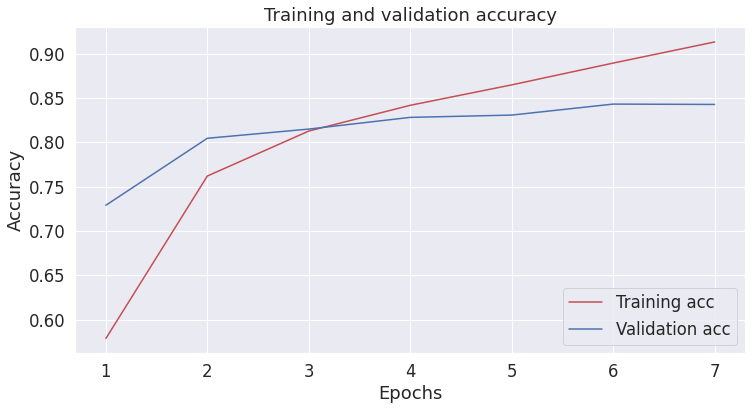

              precision    recall  f1-score   support

           0      0.801     0.895     0.845     12500
           1      0.881     0.778     0.826     12500

    accuracy                          0.836     25000
   macro avg      0.841     0.836     0.836     25000
weighted avg      0.841     0.836     0.836     25000


KFold: 6 starts.


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 108s 183ms/step - loss: 0.6934 - binary_accuracy: 0.5527 - val_loss: 0.5400 - val_binary_accuracy: 0.6802
Epoch 2/100
563/563 [==============================] - 103s 182ms/step - loss: 0.5090 - binary_accuracy: 0.7328 - val_loss: 0.4251 - val_binary_accuracy: 0.7972
Epoch 3/100
563/563 [==============================] - 102s 182ms/step - loss: 0.4019 - binary_accuracy: 0.8119 - val_loss: 0.4011 - val_binary_accuracy: 0.8210
Epoch 4/100
563/563 [==============================] - 102s 182ms/step - loss: 0.3463 - binary_accuracy: 0.8416 - val_loss: 0.3836 - val_binary_accuracy: 0.8306
Epoch 5/100
563/563 [==============================] - 102s 181ms/step - loss: 0.3019 - binary_accuracy: 0.8667 - val_loss: 0.3716 - val_binary_accuracy: 0.8356
Epoch 6/100
563/563 [==============================] - 102s 182ms/step - loss: 0.2550 - binary_accuracy

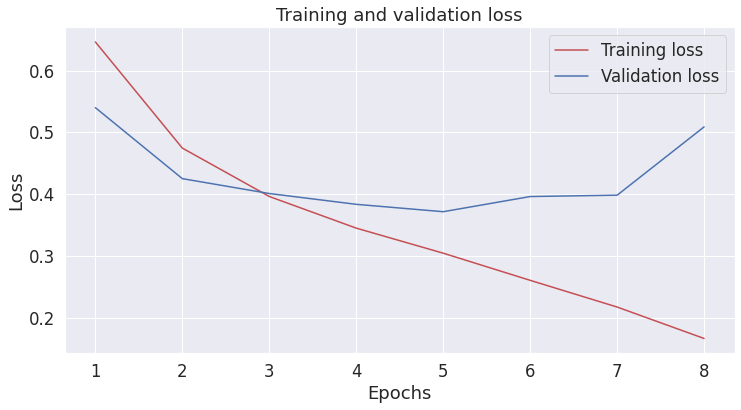

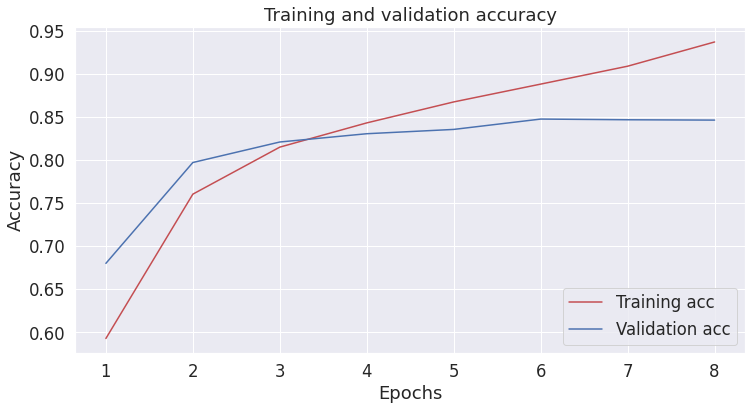

              precision    recall  f1-score   support

           0      0.815     0.892     0.852     12500
           1      0.881     0.797     0.837     12500

    accuracy                          0.845     25000
   macro avg      0.848     0.845     0.844     25000
weighted avg      0.848     0.845     0.844     25000


KFold: 7 starts.


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 108s 183ms/step - loss: 0.7007 - binary_accuracy: 0.5496 - val_loss: 0.5154 - val_binary_accuracy: 0.7502
Epoch 2/100
563/563 [==============================] - 103s 182ms/step - loss: 0.4928 - binary_accuracy: 0.7458 - val_loss: 0.4248 - val_binary_accuracy: 0.7984
Epoch 3/100
563/563 [==============================] - 102s 182ms/step - loss: 0.3957 - binary_accuracy: 0.8182 - val_loss: 0.4098 - val_binary_accuracy: 0.8210
Epoch 4/100
563/563 [==============================] - 103s 182ms/step - loss: 0.3464 - binary_accuracy: 0.8423 - val_loss: 0.3848 - val_binary_accuracy: 0.8322
Epoch 5/100
563/563 [==============================] - 102s 182ms/step - loss: 0.3091 - binary_accuracy: 0.8626 - val_loss: 0.4023 - val_binary_accuracy: 0.8346
Epoch 6/100
563/563 [==============================] - 102s 182ms/step - loss: 0.2612 - binary_accuracy

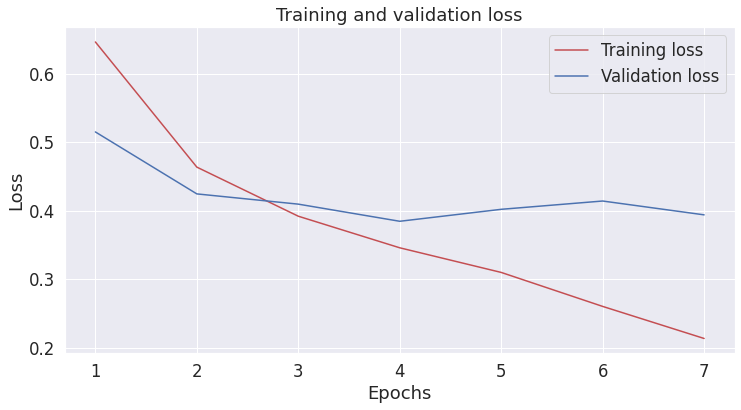

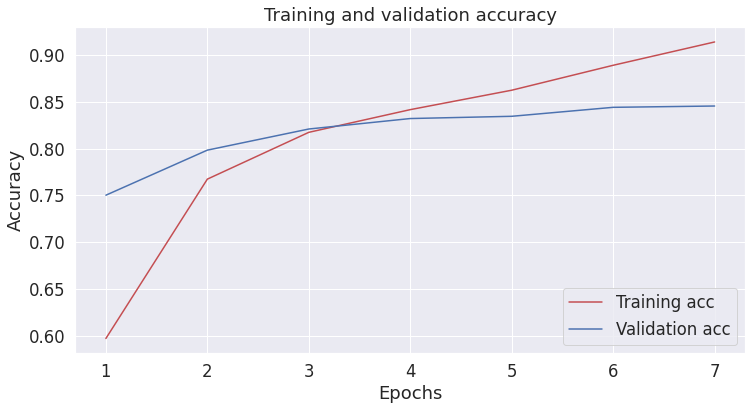

              precision    recall  f1-score   support

           0      0.820     0.873     0.845     12500
           1      0.864     0.808     0.835     12500

    accuracy                          0.841     25000
   macro avg      0.842     0.841     0.840     25000
weighted avg      0.842     0.841     0.840     25000


KFold: 8 starts.


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 108s 184ms/step - loss: 0.7946 - binary_accuracy: 0.5154 - val_loss: 0.5636 - val_binary_accuracy: 0.6478
Epoch 2/100
563/563 [==============================] - 103s 183ms/step - loss: 0.5240 - binary_accuracy: 0.7171 - val_loss: 0.4341 - val_binary_accuracy: 0.7800
Epoch 3/100
563/563 [==============================] - 103s 183ms/step - loss: 0.4172 - binary_accuracy: 0.8027 - val_loss: 0.4144 - val_binary_accuracy: 0.8074
Epoch 4/100
563/563 [==============================] - 103s 183ms/step - loss: 0.3523 - binary_accuracy: 0.8397 - val_loss: 0.3899 - val_binary_accuracy: 0.8164
Epoch 5/100
563/563 [==============================] - 103s 183ms/step - loss: 0.3073 - binary_accuracy: 0.8615 - val_loss: 0.3994 - val_binary_accuracy: 0.8140
Epoch 6/100
563/563 [==============================] - 102s 182ms/step - loss: 0.2655 - binary_accuracy

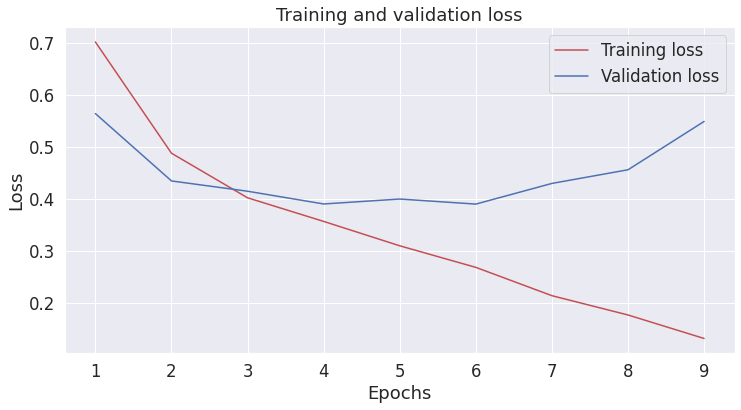

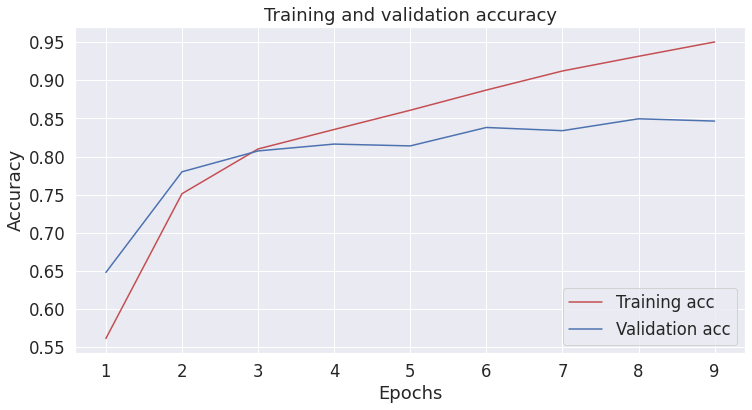

              precision    recall  f1-score   support

           0      0.855     0.853     0.854     12500
           1      0.853     0.855     0.854     12500

    accuracy                          0.854     25000
   macro avg      0.854     0.854     0.854     25000
weighted avg      0.854     0.854     0.854     25000


KFold: 9 starts.


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 109s 185ms/step - loss: 0.8419 - binary_accuracy: 0.5135 - val_loss: 0.5573 - val_binary_accuracy: 0.7108
Epoch 2/100
563/563 [==============================] - 103s 183ms/step - loss: 0.5216 - binary_accuracy: 0.7221 - val_loss: 0.4384 - val_binary_accuracy: 0.7954
Epoch 3/100
563/563 [==============================] - 103s 184ms/step - loss: 0.4171 - binary_accuracy: 0.7956 - val_loss: 0.4071 - val_binary_accuracy: 0.8184
Epoch 4/100
563/563 [==============================] - 103s 184ms/step - loss: 0.3591 - binary_accuracy: 0.8356 - val_loss: 0.3988 - val_binary_accuracy: 0.8188
Epoch 5/100
563/563 [==============================] - 103s 183ms/step - loss: 0.3109 - binary_accuracy: 0.8603 - val_loss: 0.3846 - val_binary_accuracy: 0.8364
Epoch 6/100
563/563 [==============================] - 103s 183ms/step - loss: 0.2533 - binary_accuracy

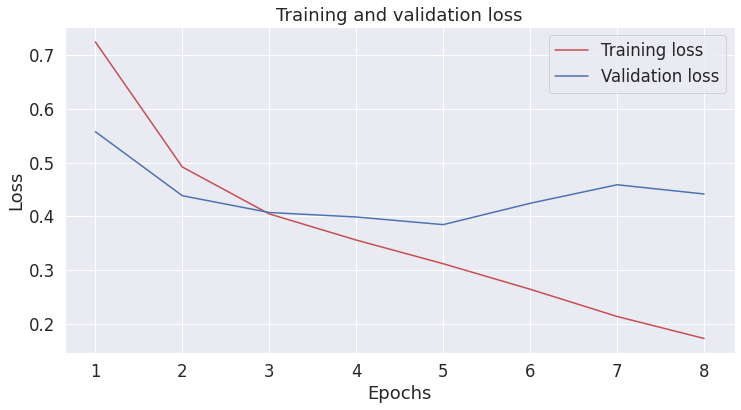

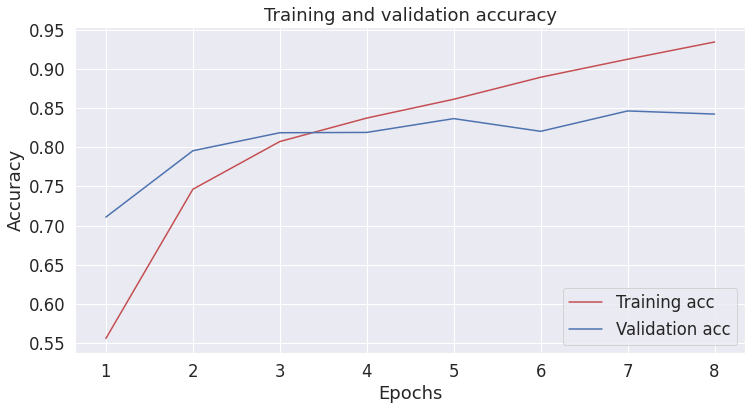

              precision    recall  f1-score   support

           0      0.818     0.889     0.852     12500
           1      0.878     0.802     0.838     12500

    accuracy                          0.845     25000
   macro avg      0.848     0.845     0.845     25000
weighted avg      0.848     0.845     0.845     25000


KFold: 10 starts.


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 110s 185ms/step - loss: 0.7084 - binary_accuracy: 0.5418 - val_loss: 0.5384 - val_binary_accuracy: 0.7076
Epoch 2/100
563/563 [==============================] - 103s 183ms/step - loss: 0.5204 - binary_accuracy: 0.7182 - val_loss: 0.4351 - val_binary_accuracy: 0.7888
Epoch 3/100
563/563 [==============================] - 103s 184ms/step - loss: 0.4083 - binary_accuracy: 0.8072 - val_loss: 0.4117 - val_binary_accuracy: 0.8022
Epoch 4/100
563/563 [==============================] - 103s 184ms/step - loss: 0.3595 - binary_accuracy: 0.8323 - val_loss: 0.3884 - val_binary_accuracy: 0.8176
Epoch 5/100
563/563 [==============================] - 103s 183ms/step - loss: 0.3100 - binary_accuracy: 0.8560 - val_loss: 0.3804 - val_binary_accuracy: 0.8428
Epoch 6/100
563/563 [==============================] - 103s 183ms/step - loss: 0.2723 - binary_accuracy

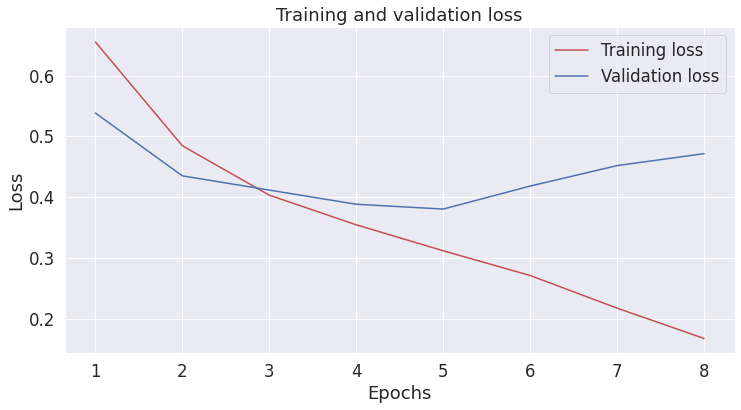

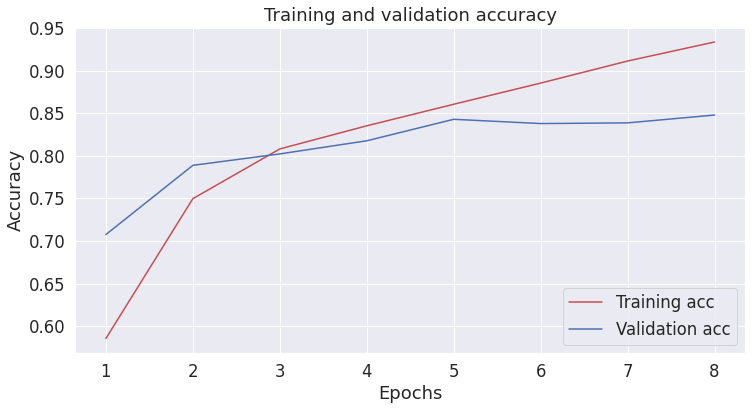

              precision    recall  f1-score   support

           0      0.839     0.859     0.849     12500
           1      0.856     0.835     0.845     12500

    accuracy                          0.847     25000
   macro avg      0.847     0.847     0.847     25000
weighted avg      0.847     0.847     0.847     25000


Average accuracy: 0.8438 (+/- 0.0051)
Average loss: 0.3598 (+/- 0.0043)
Average F1: 0.8379 (+/- 0.0090)


In [7]:
# Create and train the model

earlystop_callback = EarlyStopping(
  monitor="val_loss",
  min_delta=0.0001,
  patience=earlystopping_patience,
  restore_best_weights=True)

kfold = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)
model = None
cv_acc = []
cv_loss = []
cv_f1 = []

x_train = np.concatenate([x for x, y in train_ds], axis=0)
y_train = np.concatenate([y for x, y in train_ds], axis=0)

for n, (train, valid) in enumerate(kfold.split(x_train, y_train)):

  print("KFold: {} starts.".format(n + 1))
  del model
  tf.keras.backend.clear_session()

  text_input = Input(shape=(), dtype=tf.string, name="text")
  preprocessing_layer = KerasLayer(handle=tfhub_handle_preprocess, name="preprocessing")
  encoder_inputs = preprocessing_layer(text_input)
  encoder = KerasLayer(handle=tfhub_handle_encoder, trainable=True, name="BERT_encoder")
  outputs = encoder(encoder_inputs)
  net = outputs["pooled_output"]
  net = Dropout(rate=0.1)(net)
  net = Dense(units=1, activation=None, name="classifier")(net)
  model = Model(inputs=text_input, outputs=net)
  # plot_model(model)

  steps_per_epoch = cardinality(train_ds).numpy()
  num_train_steps = steps_per_epoch * epochs
  num_warmup_steps = int(0.1 * num_train_steps)

  optimizer = optimization.create_optimizer(init_lr=lr,
                                            num_train_steps=num_train_steps,
                                            num_warmup_steps=num_warmup_steps,
                                            optimizer_type="adamw")

  model.compile(
      optimizer=optimizer,
      loss=BinaryCrossentropy(from_logits=True),
      metrics=tf.metrics.BinaryAccuracy())

  print(f"Training model with {tfhub_handle_encoder}")
  history = model.fit(
      x=x_train[train],
      y=y_train[train],
      validation_data=val_ds,
      epochs=epochs,
      verbose=1,
      callbacks=[earlystop_callback])
  
  loss, acc = model.evaluate(test_ds, verbose=1)
  cv_acc.append(acc)
  cv_loss.append(loss)

  plot_perf(history)

  y_test = np.concatenate([y for x, y in test_ds], axis=0)
  y_pred = (model.predict(test_ds) > 0.5).astype("int32")
  report = classification_report(y_true=y_test, y_pred=y_pred, digits=3, output_dict=False)
  print(report)

  f1 = f1_score(y_true=y_test, y_pred=y_pred, average="binary")
  cv_f1.append(f1)

  print("")

print("Average accuracy: {:.4f} (+/- {:.4f})".format(np.mean(cv_acc), np.std(cv_acc)))
print("Average loss: {:.4f} (+/- {:.4f})".format(np.mean(cv_loss), np.std(cv_loss)))
print("Average F1: {:.4f} (+/- {:.4f})".format(np.mean(cv_f1), np.std(cv_f1)))
